In [102]:
from os import getcwd, path
from pathlib import Path
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import numpy as np

# Import the dataset

In [103]:
def get_directory(directory_name: str) -> str:
    return path.join(Path(getcwd()).parents[1], 'dataset', directory_name)

# Visualize the dataset

In [104]:
IMG_SIZE = 227
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

def file_count(dir_name: str) -> int:
    return len(np.concatenate([i for _, i in dir_name], axis=0))

def get_images(dir_name: str):
    return keras.preprocessing.image_dataset_from_directory(get_directory(dir_name),
                                                            #color_mode='grayscale',
                                                            subset='both',
                                                            label_mode='categorical',
                                                            validation_split=VALIDATION_SPLIT,
                                                            seed=1,
                                                            image_size=(IMG_SIZE, IMG_SIZE),
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True)

train_ds, valid_ds = get_images('all_data')

count = (3 * tf.data.experimental.cardinality(valid_ds)) // 4
test_ds = valid_ds.take(count)
valid_ds = valid_ds.skip(count)

print("Using", file_count(test_ds), "files for testing and", file_count(valid_ds), "files for validation.")

Found 2273 files belonging to 5 classes.
Using 1819 files for training.
Using 454 files for validation.
Using 384 files for testing and 70 files for validation.


In [105]:
data_augmentation = keras.Sequential([ keras.layers.RandomFlip('horizontal_and_vertical'), keras.layers.RandomRotation(0.1) ])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

valid_ds = valid_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

test_ds = valid_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

train_imgs = train_ds.map(lambda imgs, _: imgs)
normalization_layer = keras.layers.Normalization(axis=-1)
normalization_layer.adapt(train_imgs)

train_set_normalized = train_ds.map(lambda imgs, labels: (normalization_layer(imgs), labels), num_parallel_calls=tf.data.AUTOTUNE)
validation_set_normalized = valid_ds.map(lambda imgs, labels: (normalization_layer(imgs), labels), num_parallel_calls=tf.data.AUTOTUNE)
test_set_normalized = test_ds.map(lambda imgs, labels: (normalization_layer(imgs), labels), num_parallel_calls=tf.data.AUTOTUNE)

29 total batches
(64, 227, 227, 3) (64, 5)


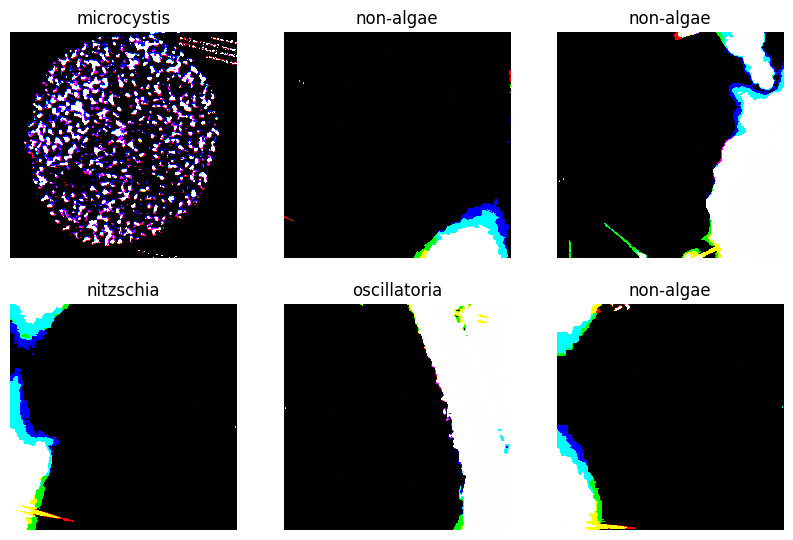

In [106]:
CATEGORIES = sorted([ 'closterium', 'microcystis', 'nitzschia', 'non-algae', 'oscillatoria' ])
print(len(train_set_normalized), 'total batches')

plt.figure(figsize=(10, 10))
for images, labels in train_set_normalized.take(1):
    print(images.shape, labels.shape)
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='binary_r')
        plt.title(CATEGORIES[labels[i].numpy().argmax()])
        plt.axis("off")

# Build and compile the model

In [107]:
# Prefetching samples in GPU memory helps maximize GPU utilization
train_set_normalized = train_set_normalized.prefetch(tf.data.AUTOTUNE)
validation_set_normalized = validation_set_normalized.prefetch(tf.data.AUTOTUNE)

model = keras.Sequential([
  keras.layers.Input(shape=(images.shape[1:])),# batch_size=images.shape[0]),

  keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=3, strides=2),
  keras.layers.BatchNormalization(momentum=0.9),

  keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=3, strides=1),
  keras.layers.BatchNormalization(momentum=0.9),

  keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', strides=2, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=3, strides=1),
  keras.layers.BatchNormalization(momentum=0.9),

  keras.layers.Flatten(),
  
  keras.layers.Dense(1024, activation='relu'), # input_shape=(prod(image_batch.shape[1:]),),
  keras.layers.BatchNormalization(momentum=0.9),
  
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.BatchNormalization(momentum=0.9),
  
  keras.layers.Dense(len(CATEGORIES), activation='softmax')
])

model.compile(optimizer='adam',#
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)      │      4,864 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 55, 55, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_5           │ (None, 55, 55, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)        │    102,464 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_6           │ (None, 26, 26, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 128)       │    204,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_7           │ (None, 11, 11, 128)       │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 15488)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 1024)              │ 15,860,736 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_8           │ (None, 1024)              │      4,096 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 1024)              │  1,049,600 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_9           │ (None, 1024)              │      4,096 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 5)                 │      5,125 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,236,933 (65.75 MB)

 Trainable params: 17,232,325 (65.74 MB)

 Non-trainable params: 4,608 (18.00 KB)

# Train the model

In [108]:
history = model.fit(train_set_normalized,
                    validation_data=validation_set_normalized,
                    validation_split=VALIDATION_SPLIT,
                    epochs=5,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    shuffle=True,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max')]
                    )

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.2906 - loss: 3.0110 - val_accuracy: 0.3286 - val_loss: 1.6680
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.4345 - loss: 1.4789 - val_accuracy: 0.4571 - val_loss: 1.4271
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.4744 - loss: 1.2891 - val_accuracy: 0.4143 - val_loss: 1.5735
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.5056 - loss: 1.2193 - val_accuracy: 0.4714 - val_loss: 1.7655
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5570 - loss: 1.1615 - val_accuracy: 0.5143 - val_loss: 1.4890


# Evaluate accuracy

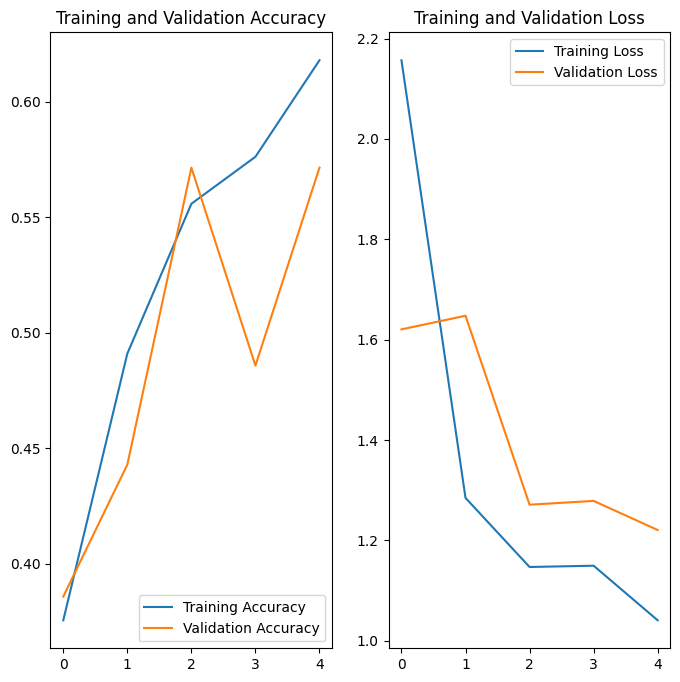

In [33]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

loss, val_loss = history.history['loss'], history.history['val_loss']
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing

In [95]:
model.evaluate(test_ds,
               batch_size=BATCH_SIZE,
               verbose=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.0694 - loss: 308.9815


[304.4268798828125, 0.078125]

# Predicting

In [93]:
INDEX = 63 # [0, 63]

images, labels = next(iter(test_ds.take(1)))

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
prediction = model.predict(tf.expand_dims(keras.utils.img_to_array(images[INDEX].numpy().astype('uint8')), 0),
                            verbose = 0, 
                            )

print("Prediction:", CATEGORIES[prediction.argmax()])
print("Correct Category:", CATEGORIES[labels[INDEX].numpy().argmax()])

Prediction: closterium
Correct Category: non-algae
